In [113]:
import torch

In [114]:
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy.io
from tqdm import tqdm


plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 10})


<h2>Exer 6.3.i</h2>

In [115]:
#Load data

mat_contents = scipy.io.loadmat(os.path.join('CYLINDER_ALL.mat')) 

vortall = mat_contents['VORTALL']
#Uall = mat_contents['UALL']
#Vall = mat_contents['VALL']

m, n = *mat_contents['m'], *mat_contents['n']

In [116]:
P = 0.4

Train = vortall[:, :int(vortall.shape[1]*P)]
Test = vortall[:, int(vortall.shape[1]*P)-1:]

torch.manual_seed(0)
load = torch.utils.data.DataLoader(Train.T, batch_size=2)


In [117]:
class FeedForward(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
                                nn.Linear(self.input_dim, self.input_dim),
                                nn.GELU(),
                                #nn.Dropout(dropout),
                                #nn.Linear(input_dim, input_dim),
                                nn.Linear(self.input_dim, self.input_dim)
                                #nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

    
class Model(FeedForward):
    def __init__(self, shapes, learn_rate=1e-2):
        self.input_dim = shapes[0]
        self.num_chunks = shapes[1]
        self.learn_rate = learn_rate
        super().__init__()
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr=self.learn_rate)
        self.chunk_pred = []
        self.loss = []
        self.validation = []

    
    #fit by chunks to avoid killing the kernel
    def chunks(self, max_layer_input, divider):
        return [(i*max_layer_input//divider, (i+1)*max_layer_input//divider) for i in range(divider)]
    
    def train(self, data_loader, tot_iters):
        for tot_iter in tqdm(range(tot_iters)):
            for tot_samp_idx, (train, test) in enumerate(data_loader):
                for (start, end) in self.chunks(self.input_dim*self.num_chunks, self.num_chunks):
                    train_chunk, test_chunk = train[start:end].float(), test[start:end].float()
                    net_real = self.net(train_chunk)
                    self.chunk_pred.append(net_real)

                    self.optimizer.zero_grad()
                    loss = nn.MSELoss()(net_real, test_chunk)
                    loss.backward()
                    self.optimizer.step()

                    
                self.loss.append(nn.MSELoss()(torch.ravel(torch.stack(self.chunk_pred)), test).data.item())
                self.chunk_pred = []
                    
    def predict(self, data_loader):
        self.chunk_pred = []
        for pair_idx, (X_test, Y_test) in enumerate(data_loader):
            for (start, end) in self.chunks(self.input_dim*self.num_chunks, self.num_chunks):
                X_test_chunk, Y_test_chunk = X_test[start:end].float(), Y_test[start:end].float()
                net_real = self.net(X_test_chunk)
                self.chunk_pred.append(net_real)

            self.validation.append(nn.MSELoss()(torch.ravel(torch.stack(self.chunk_pred)), Y_test).data.item())
            self.chunk_pred = []
                
    def plottrain(self):
        plt.figure(figsize=(5,5))
        plt.plot(self.loss)
        plt.title('Training Data MSE')
        plt.xlabel('Tot_iter * Tot_samp')

    def plottest(self):
        plt.figure(figsize=(5,5))
        plt.plot(self.validation)
        plt.title('Testing Data MSE')
        plt.xlabel('Pair index');



In [118]:
torch.manual_seed(0)
net = Model(shapes=(int(*n),int(*m)), learn_rate=1e-2)
net.train(load, 50)

100%|██████████| 50/50 [11:31<00:00, 13.83s/it]


In [119]:
#Test MSE

torch.manual_seed(0)
Testing = torch.utils.data.DataLoader(Test.T, batch_size=2)
net.predict(Testing)

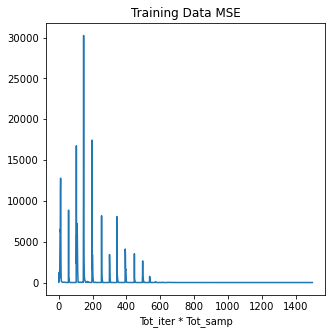

In [120]:
net.plottrain()

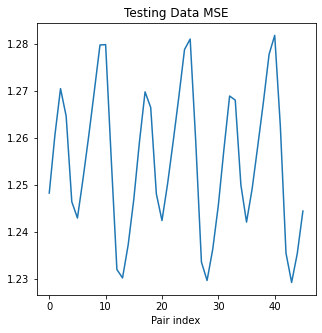

In [121]:
net.plottest()

In [122]:
#Redo the forecasting calculations by training a model in the reduced subspace U

U, S, VT = np.linalg.svd(vortall, full_matrices=False) 

In [123]:
P = 0.4
Train = U[:, :int(U.shape[1]*P)]
Test = U[:, int(U.shape[1]*P)-1:]

torch.manual_seed(0)
load = torch.utils.data.DataLoader(Train.T, batch_size=2)
net = Model(shapes=(int(*n),int(*m)), learn_rate=1e-2)
net.train(load, 50)

100%|██████████| 50/50 [1:31:01<00:00, 109.23s/it]


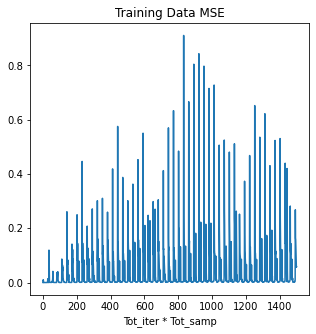

In [124]:
#Test MSE
torch.manual_seed(0)
Testing = torch.utils.data.DataLoader(Test.T, batch_size=2)
net.predict(Testing)
net.plottrain()

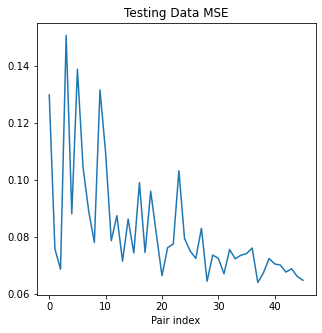

In [125]:
net.plottest()

<p>For a fixed p = 0.4, note that the forecast from the reduced subspace U is better. We will stop at a fixed point p since the computation time to variate the p values is too long. </p>